In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def kijun_sen(df,n=26):
    df['Kijun Sen'] = (df['High'].rolling(n).max() + df['High'].rolling(n).min())/2

Strategy: Buy when cross up from SSL channel, and close of candle above Kijun Sen, and WAE over WAE moving average.  Risk: stop_loss is 1.5 atr below close of candle, take half profit at 1 atr above close move stop loss to close, and have other half run until cross down of SSL channel or stopped out.

In [3]:
def SSL_Channel(df, n=14):
    up = [np.nan]*n
    dn = [np.nan]*n
    for i in range(n,len(df)):
        highs = [df['High'][k] for k in range(i-n, i)]
        high_avg = sum(highs)/len(highs)
        lows = [df['Low'][k] for k in range(i-n, i)]
        low_avg = sum(lows)/len(lows)
        
        close = df['Close'][i]
        if close > high_avg:
            up.append(high_avg)
            dn.append(low_avg)
        elif close < low_avg:
            up.append(low_avg)
            dn.append(high_avg)
        else:
            up.append(high_avg)
            dn.append(low_avg)
    
    df['SSL_up'] = up
    df['SSL_dn'] = dn

In [4]:
def ATR(df,n=14):
    "function to calculate True Range and Average True Range"
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df = df.drop(['H-L','H-PC','L-PC'],axis=1)

In [5]:
def backtest(df):
    df = df.dropna()
    cash = 100000
    sold_half = False
    
    position = None
    trades = []
    profit = 0
    buy = [np.nan]
    sell = [np.nan]
    for i in range(1,len(df)):
        if not position:
            #Data
            prev_up = df['SSL_up'][i-1]
            prev_dn = df['SSL_dn'][i-1]
            ssl_up = df['SSL_up'][i]
            ssl_dn = df['SSL_dn'][i]
            kijun_sen = df['Kijun Sen'][i]
            close = df['Close'][i]
            atr = df['ATR'][i]
            #Buy indicators
            cross_ssl = prev_up < prev_dn and ssl_up > ssl_dn
            above_ks = close > kijun_sen
            
            if cross_ssl and above_ks:
                stop_loss = close - 1.5*atr
                take_profit = close + atr
                qty = 0.02*cash//(close-stop_loss)
                buy.append(close)
                print('Bought for',close)
                sell.append(np.nan)
                position = {'buy_price':close,'qty':qty,'stop_loss':stop_loss,'take_profit':take_profit}
            else:
                buy.append(np.nan)
                sell.append(np.nan)
        elif position:
            avg_price = (df['Close'][i] + df['Open'][i])/2
            prev_up = df['SSL_up'][i-1]
            prev_dn = df['SSL_dn'][i-1]
            ssl_up = df['SSL_up'][i]
            ssl_dn = df['SSL_dn'][i]
            
            #Sell indicators
            stop_loss = df['Low'][i] <= position['stop_loss']
            take_profit = df['High'][i] >= position['take_profit']
            cross_down = prev_up > prev_dn and ssl_dn > ssl_up
            
            if stop_loss or (cross_down and sold_half) or i == len(df)-1:
                trades.append({'buy_price'  : position['buy_price'], 
                               'sell_price' : avg_price, 
                               'qty'        : position['qty'],
                               'pandl'      : (avg_price - position['buy_price'])*position['qty']})
                profit += (avg_price - position['buy_price'])*position['qty']
                print('Sold for', (avg_price - position['buy_price'])*position['qty'])
                position = None
                sell.append(avg_price)
                buy.append(np.nan)
                sold_half = False
            
            elif take_profit and not sold_half:
                position['qty'] = position['qty'] - position['qty']//2
                trades.append({'buy_price'  : position['buy_price'], 
                               'sell_price' : avg_price, 
                               'qty'        : position['qty']//2,
                               'pandl'      : (avg_price - position['buy_price'])*(position['qty']//2)})
                position['stop_loss'] = position['buy_price']
                profit += (position['qty']//2)*(avg_price-position['buy_price'])
                print('Sold half for',(position['qty']//2)*(avg_price-position['buy_price']))
                buy.append(np.nan)
                sell.append(avg_price)
                position['take_profit'] = float('inf')
                sold_half = True
            else:
                sell.append(np.nan)
                buy.append(np.nan)
    print(profit)
    print(len(trades),'trades')
    winners = [trade['pandl'] for trade in trades if trade['pandl'] > 0]
    losers = [trade['pandl'] for trade in trades if trade['pandl'] <= 0]
    print('Winners:',len(winners))
    print('Losers:',len(losers))
    
    plt.figure(figsize=(16,8))
    plt.plot(df['Close'],alpha = 0.5)
    plt.plot(df['SSL_up'], color='green')
    plt.plot(df['SSL_dn'], color='red')
    plt.plot(df['Kijun Sen'], color='grey',alpha=0.5)
    for i in range(len(buy)):
        if not np.isnan(buy[i]):
            plt.text(df.index[i],buy[i], f'${round(buy[i],2)}')
        if not np.isnan(sell[i]):
            plt.text(df.index[i],sell[i],f'${round(sell[i],2)}')
    plt.scatter(df.index, buy, marker='^',color='green', s=70)
    plt.scatter(df.index, sell, marker='v',color='red',s=70)
    plt.show()

[*********************100%***********************]  1 of 1 completed
Bought for 189.9499969482422
Sold half for 113.90563201904297
Sold for 200.38520050048828
Bought for 192.22999572753906
Sold half for 294.4150924682617
Sold for 963.5408630371094
Bought for 192.16000366210938
Sold for -1419.180908203125
Bought for 152.91000366210938
Sold half for 290.19012451171875
Sold for -42.84136962890625
Bought for 162.08999633789062
Sold half for 124.0806884765625
Sold for 205.86094665527344
Bought for 168.0800018310547
Sold for -2392.4263458251953
Bought for 239.4499969482422
Sold half for 206.74539947509766
Sold for 395.7811279296875
Bought for 240.9499969482422
Sold half for 287.9505157470703
Sold for 1190.8004760742188
Bought for 225.1199951171875
Sold for -2320.496368408203
Bought for 223.8300018310547
Sold for -3041.8006134033203
Bought for 242.02999877929688
Sold half for 175.2001953125
Sold for 306.7060317993164
Bought for 256.8299865722656
Sold half for 159.97572326660156
Sold for 76.63

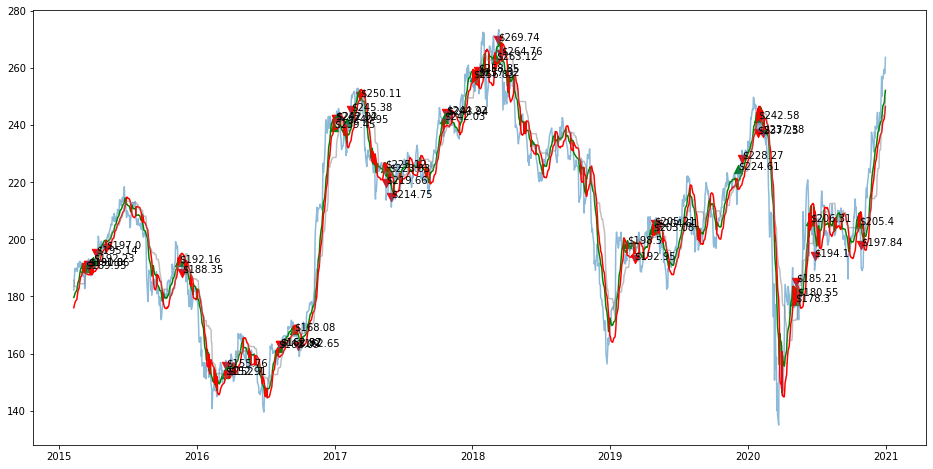

[*********************100%***********************]  1 of 1 completed
Bought for 58.47999954223633
Sold half for 88.74028015136719
Sold for 67.43037414550781
Bought for 51.40999984741211
Sold for -878.3559894561768
Bought for 36.130001068115234
Sold half for 141.67986488342285
Sold for 190.125
Bought for 37.43000030517578
Sold half for 297.370059967041
Sold for 4781.5
Bought for 58.650001525878906
Sold half for 468.7195129394531
Sold for 780.6798973083496
Bought for 26.670000076293945
Sold half for 110.16004943847656
Sold for 56.22546195983887
Bought for 26.489999771118164
Sold for -1553.7598571777344
Bought for 32.560001373291016
Sold for -784.7409524917603
Bought for 38.349998474121094
Sold for -1992.299301147461
Bought for 36.650001525878906
Sold half for 13.274459838867188
Sold for -908.6005401611328
Bought for 36.189998626708984
Sold half for 157.08007049560547
Sold for 468.9305992126465
Bought for 38.900001525878906
Sold half for 417.1045665740967
Sold for 266.1086769104004
Bought

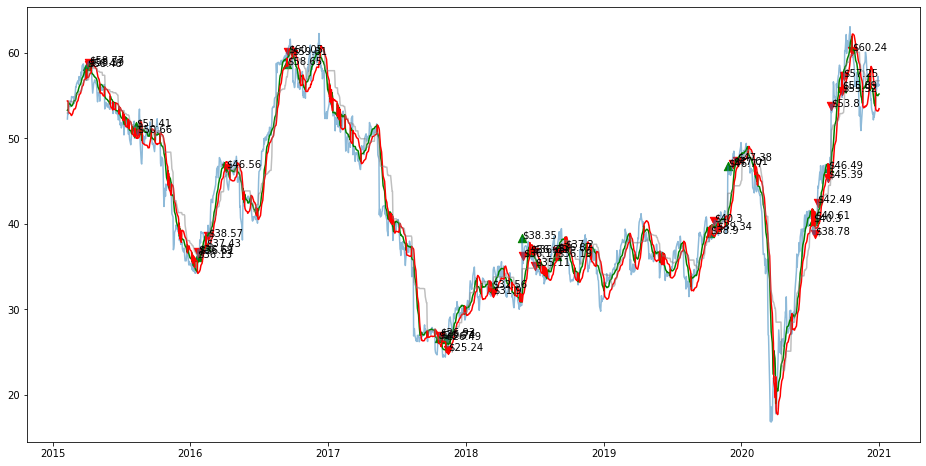

[*********************100%***********************]  1 of 1 completed
Bought for 31.760000228881836
Sold for -1716.9004440307617
Bought for 31.899999618530273
Sold half for 242.37537384033203
Sold for -246.74930572509766
Bought for 29.69499969482422
Sold for -1530.9343566894531
Bought for 25.737499237060547
Sold half for 453.72127532958984
Sold for 1804.0735330581665
Bought for 26.9325008392334
Sold for -1540.0307655334473
Bought for 38.29499816894531
Sold half for 233.29242324829102
Sold for -382.7002601623535
Bought for 40.375
Sold half for 35.308841705322266
Sold for -522.8716506958008
Bought for 43.28499984741211
Sold for -1046.1482906341553
Bought for 42.962501525878906
Sold for -1914.342212677002
Bought for 55.962501525878906
Sold half for 91.70857429504395
Sold for 155.68744277954102
Bought for 52.630001068115234
Sold for -1443.118408203125
Bought for 55.20500183105469
Sold half for 455.53789138793945
Sold for 6298.929595947266
Bought for 66.3949966430664
Sold half for 293.503723

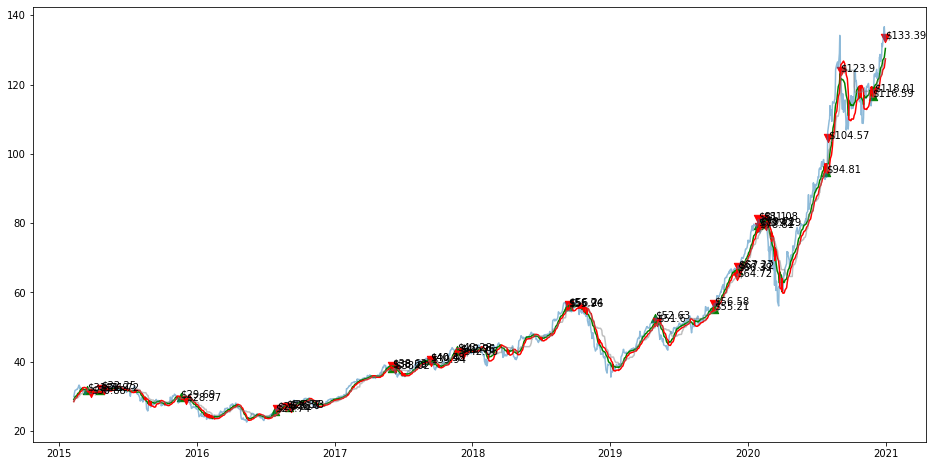

[*********************100%***********************]  1 of 1 completed
Bought for 210.4600067138672
Sold for -1793.508415222168
Bought for 210.72000122070312
Sold for -1297.9239196777344
Bought for 211.6199951171875
Sold half for 219.0156707763672
Sold for -22.049903869628906
Bought for 210.07000732421875
Sold for -1638.2007064819336
Bought for 210.57000732421875
Sold for -1775.7305145263672
Bought for 208.72999572753906
Sold for -877.3068084716797
Bought for 209.6199951171875
Sold for -1687.7964477539062
Bought for 208.02999877929688
Sold for -2939.3025665283203
Bought for 207.97000122070312
Sold for -1299.107810974121
Bought for 208.4499969482422
Sold for -1101.0511016845703
Bought for 210.80999755859375
Sold for -5096.119728088379
Bought for 216.17999267578125
Sold half for 272.06134033203125
Sold for 669.9313430786133
Bought for 218.36000061035156
Sold for -919.4927291870117
Bought for 218.3699951171875
Sold for -3141.1552734375
Bought for 225.24000549316406
Sold half for 347.1894149

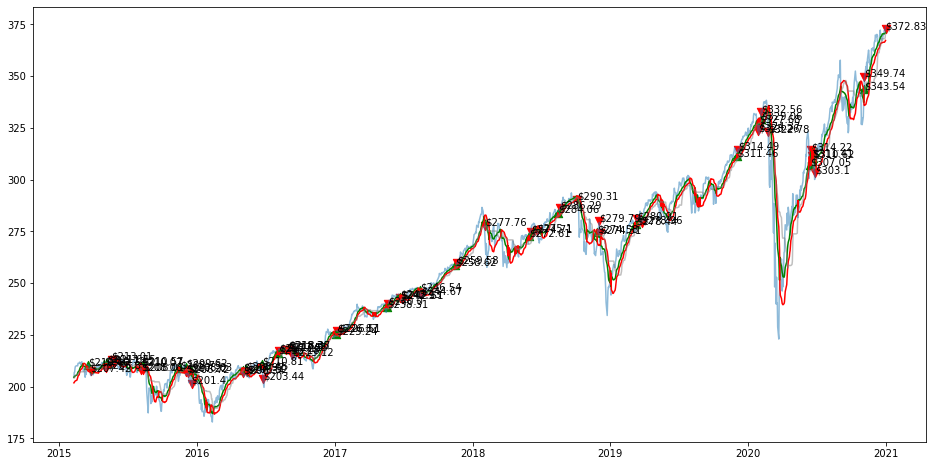

[*********************100%***********************]  1 of 1 completed
Bought for 10.0
Sold half for 474.5395474433899
Sold for 7434.9266810417175
Bought for 18.5
Sold half for 185.52494525909424
Sold for 268.5498905181885
Bought for 17.389999389648438
Sold for -1722.1594381332397
6641.38162612915
5 trades
Winners: 4
Losers: 1


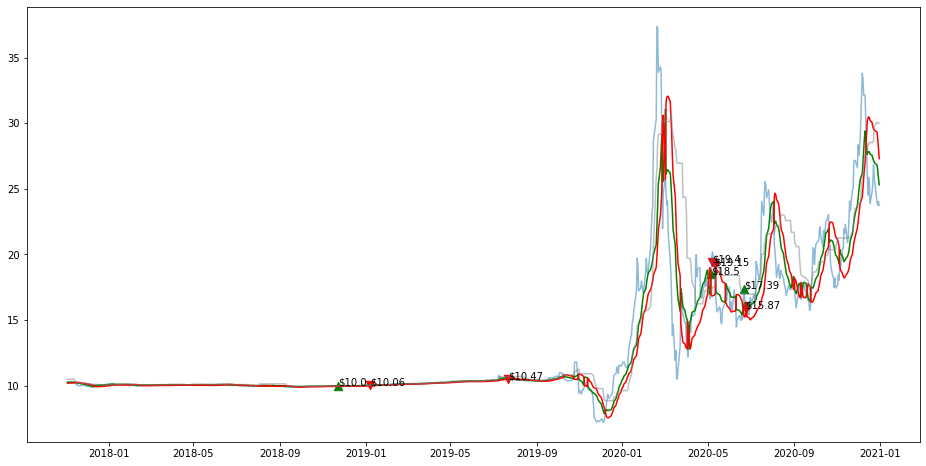

[*********************100%***********************]  1 of 1 completed
Bought for 153.6699981689453
Sold half for 179.8194580078125
Sold for 248.64117431640625
Bought for 152.6699981689453
Sold for -492.24815368652344
Bought for 144.9499969482422
Sold for -1360.379493713379
Bought for 146.0800018310547
Sold half for 184.08004760742188
Sold for 40.68914031982422
Bought for 147.74000549316406
Sold for -912.6632995605469
Bought for 148.5
Sold for -1569.9711227416992
Bought for 131.89999389648438
Sold for -1366.9210815429688
Bought for 129.8699951171875
Sold for -1285.722942352295
Bought for 130.08999633789062
Sold half for 145.79983520507812
Sold for 131.28572845458984
Bought for 180.10000610351562
Sold for -1158.125
Bought for 182.6999969482422
Sold for -1148.5594635009766
Bought for 183.6699981689453
Sold half for 313.56092834472656
Sold for 12358.710571289062
Bought for 239.75
Sold for -1192.5511932373047
Bought for 340.9100036621094
Sold half for 98.88966369628906
Sold for -120.64010620

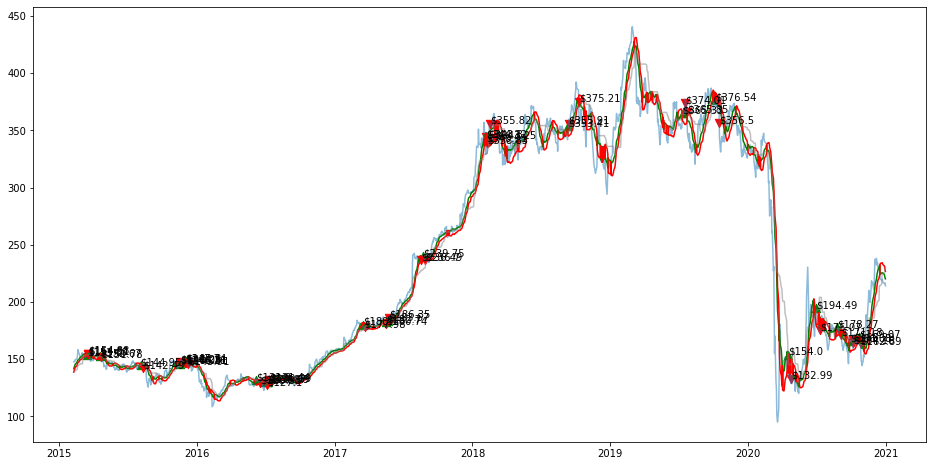

[*********************100%***********************]  1 of 1 completed
Bought for 14.359999656677246
Sold for -2289.037817001343
Bought for 13.199999809265137
Sold half for 274.5603332519531
Sold for -24.959381103515625
Bought for 12.699999809265137
Sold for -1465.5893154144287
Bought for 12.119999885559082
Sold half for 146.4007329940796
Sold for 237.90020942687988
Bought for 12.1899995803833
Sold half for 316.16571712493896
Sold for 222.23682594299316
Bought for 12.579999923706055
Sold half for 320.1807851791382
Sold for -914.9991273880005
Bought for 11.430000305175781
Sold half for -59.13072681427002
Sold for -460.07550144195557
Bought for 9.399999618530273
Sold half for 304.9807071685791
Sold for -83.75349378585815
Bought for 9.300000190734863
Sold for -1635.5707340240479
Bought for 9.180000305175781
Sold for -6713.341405391693
Bought for 5.239999771118164
Sold for -2117.359309196472
Bought for 5.309999942779541
Sold half for 290.03002405166626
Sold for 2838.375
Bought for 6.69000005

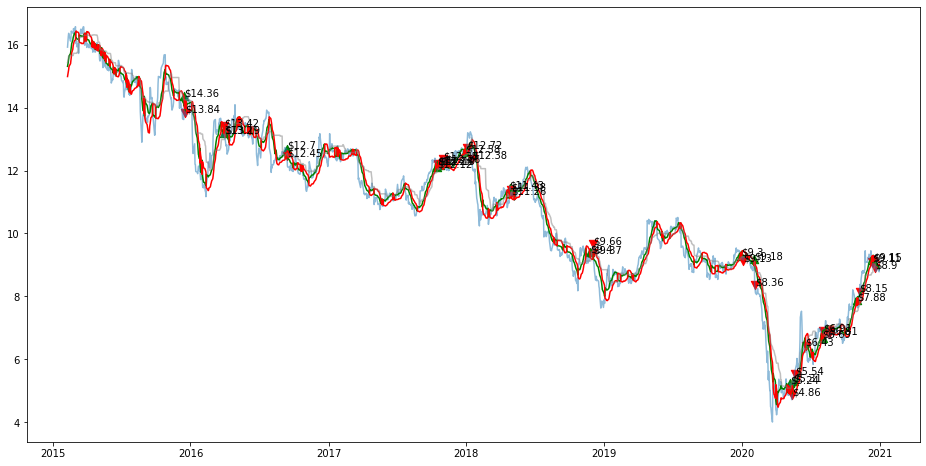

In [6]:
tickers=['GS','DKS','AAPL','SPY','SPCE','BA','F']
for ticker in tickers:
    data = yf.download(ticker,'2015-01-01','2021-01-01')
    kijun_sen(data)
    SSL_Channel(data)
    ATR(data)
    backtest(data)